In [1]:
import matplotlib
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import colors as mcolors
from matplotlib.legend import Legend
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [2]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
import astropy.units as u
import statistics as stats

In [3]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

In [4]:
#read in eBOSS file
hdu = fits.open('/Users/quinncasey/Desktop/research/eboss/spLine_trim_dr16_eboss.fits')

In [5]:
hdu[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  336 /Number of bytes per row                         
NAXIS2  =              1910807 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   82 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [6]:
# Defining variables
ha = hdu[1].data['H_ALPHA_FLUX'].tolist()
ha_err = hdu[1].data['H_ALPHA_FLUX_ERR'].tolist()
hb = hdu[1].data['H_BETA_FLUX'].tolist()
hb_err = hdu[1].data['H_BETA_FLUX_ERR'].tolist()
o3 = hdu[1].data['OIII_5007_FLUX'].tolist()
o3_err = hdu[1].data['OIII_5007_FLUX_ERR'].tolist()
n2 = hdu[1].data['NII_6584_FLUX'].tolist()
n2_err = hdu[1].data['NII_6584_FLUX_ERR'].tolist()

hb_ew = hdu[1].data['H_BETA_EW'].tolist()
hb_ew_err = hdu[1].data['H_BETA_EW_ERR'].tolist()

z = hdu[1].data['Z'].tolist()

plate = hdu[1].data['PLATE'].tolist()
mjd = hdu[1].data['MJD'].tolist()
fiber = hdu[1].data['FIBER'].tolist()

In [7]:
# create a dataframe w/the variables
data_names = ['ha', 'ha_err', 'hb', 'hb_err', 'o3', 'o3_err', 'n2', 'n2_err', 'z', 'hb_ew', 'hb_ew_err', 'plate', 'mjd', 'fiber']
data_dict = {'ha':ha, 'ha_err':ha_err, 'hb':hb, 'hb_err':hb_err, 'o3':o3, 'o3_err':o3_err, 'n2':n2, 'n2_err':n2_err, 'hb_ew':hb_ew, 'hb_ew_err':hb_ew_err, 'z':z, 'plate':plate, 'mjd':mjd, 'fiber':fiber}
df = pd.DataFrame(data_dict)

In [8]:
for name in data_names: 
    df = df.loc[df[name].notnull()]

In [9]:
# making SNR cuts
df = df.loc[(df['ha']/df['ha_err']) > 3]
df = df.loc[(df['hb']/df['hb_err']) > 3]
df = df.loc[(df['o3']/df['o3_err']) > 3]
df = df.loc[(df['n2']/df['n2_err']) > 3]

In [10]:
df1 = df.query('z > 0.4 & z <= 0.5')

In [11]:
print(df1.loc[:,"z"].median())

0.4584362357854843


In [12]:
print(cosmo.age(0.4584362357854843))

8.730017835578247 Gyr


In [13]:
def z_zero_kewl_line():
    x = np.linspace(-2, 0, 500)
    y = 0.61/(x-0.02)+1.2
    return x, y

def agn_classification_line_mod():
    x = np.linspace(-2, 0, 500)
    y = (0.61/(x-0.02-0.1833*(df1.loc[:,"z"].median())))+1.4+0.03*(df1.loc[:,"z"].median())
    return x, y

In [14]:
def low_met_agn(df1): 
    x_values = df1.x.values
    y_values = df1.y.values.tolist()
    
    z_1 = df1['z'].values
    ha_1 = df1['ha'].values
    ha_err_1 = df1['ha_err'].values
    hb_1 = df1['hb'].values
    hb_err_1 = df1['hb_err'].values
    o3_1 = df1['o3'].values
    o3_err_1 = df1['o3_err'].values
    n2_1 = df1['n2'].values
    n2_err_1 = df1['n2_err'].values
    hb_ew_1 = df1['hb_ew'].values
    hb_ew_err_1 = df1['hb_ew_err'].values
    
    plate_1 = df1['plate'].values
    mjd_1 = df1['mjd'].values
    fiber_1 = df1['fiber'].values
    
    kewl_agn_class_line_mod = (0.61/(x_values-0.02-0.1833*(df1.loc[:,"z"].median())))+1.4+0.03*(df1.loc[:,"z"].median())
    
    df1 = []
    
    for x, y, agn_line in zip(x_values, y_values, kewl_agn_class_line_mod):
        if x < -0.8 and y > agn_line:
            df1.append('lowmetagn')
        elif x >=-0.8 and y > agn_line:
            df1.append('agn')
        elif x > 0.0:
            df1.append('agn')
        else: 
            df1.append('starform')
            
    return df1, ha_1, ha_err_1, hb_1, hb_err_1, n2_1, n2_err_1, o3_1, o3_err_1, z_1, hb_ew_1, hb_ew_err_1, plate_1, mjd_1, fiber_1

In [15]:
df1['x'] = np.log10(df1['n2']/df1['ha'])
df1['y'] = np.log10(df1['o3']/df1['hb'])

df2 = low_met_agn(df1)

/Users/quinncasey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/quinncasey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
df2 = pd.DataFrame(df2)
df2 = df2.transpose()

In [17]:
df2.columns = ['Type', 'ha', 'ha_err', 'hb', 'hb_err', 'n2', 'n2_err', 'o3', 'o3_err', 'z', 'hb_ew', 'hb_ew_err', 'plate', 'mjd', 'fiber']

In [18]:
dfagn = df2[df2.Type != 'starform']
dfsf = df2[df2.Type != 'agn']
dflowmetagn = df2[df2.Type != 'agn']

dfagn = dfagn[dfagn.Type != 'lowmetagn']
dfsf = dfsf[dfsf.Type != 'lowmetagn']
dflowmetagn = dflowmetagn[dflowmetagn.Type != 'starform']

In [19]:
print(len(dfagn))
print(len(dfsf))
print(len(dflowmetagn))

7934
5330
22


In [20]:
def plot_bpt(nii,halpha,oiii,hbeta,nii2,halpha2,oiii2,hbeta2,nii3,halpha3,oiii3,hbeta3,fig=None,**kwargs):
    halpha=np.array(halpha,dtype=float)
    halpha2=np.array(halpha2,dtype=float)
    halpha3=np.array(halpha3, dtype=float)
    nii=np.array(nii,dtype=float)
    nii2=np.array(nii2,dtype=float)
    nii3=np.array(nii3,dtype=float)
    hbeta=np.array(hbeta,dtype=float)
    hbeta2=np.array(hbeta2,dtype=float)
    hbeta3=np.array(hbeta3,dtype=float)
    oiii=np.array(oiii,dtype=float)
    oiii2=np.array(oiii2,dtype=float)
    oiii3=np.array(oiii3,dtype=float)
    n2ha=np.log10(nii/halpha)
    o3hb=np.log10(oiii/hbeta)
    n2ha2=np.log10(nii2/halpha2)
    o3hb2=np.log10(oiii2/hbeta2)
    n2ha3=np.log10(nii3/halpha3)
    o3hb3=np.log10(oiii3/hbeta3)
    
    plt.style.use('grayscale')
    
    starform = plt.scatter(n2ha,o3hb, c='dimgray', s=1, **kwargs)
    low_met_agn = plt.scatter(n2ha2,o3hb2, c='r', s=5, **kwargs)
    agn = plt.scatter(n2ha3,o3hb3, c='slategray', s=1, **kwargs)
    
    agn_class=agn_classification_line_mod()
    z_zero = z_zero_kewl_line()
    #plotting the mixing line
    mix=plt.plot([-0.466, 0.003], [-0.408, 0.979], c='r')
    agn_0=plt.plot(agn_class[0], agn_class[1], c='b')
    agn_1=plt.plot(z_zero[0], z_zero[1], c='coral', linestyle='--')
    
    plt.xlim(-2.0,0.75)
    plt.ylim(-1.25,1.75)
    plt.legend([starform, low_met_agn, agn], ['Star Forming (N=5330)', 'Low Metallicity AGNs (N=22)', 'AGNs (N=7934)'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title('Median Z~0.458 -- Universe 8.73 Gyr Old')
    plt.xlabel(r'$log_{10}($[NII]/h$\alpha)$')
    plt.ylabel(r'$log_{10}($[OIII]/h$\beta)$')
    plt.show()
    return

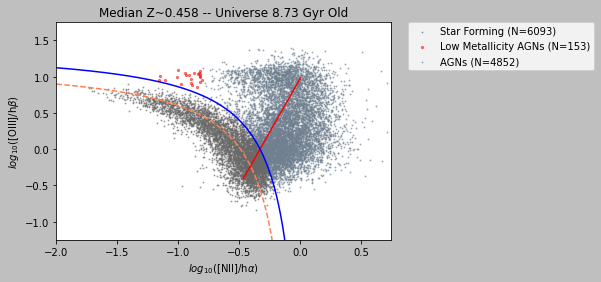

In [21]:
halpha = dfsf['ha'].values
halpha2 = dflowmetagn['ha'].values
halpha3 = dfagn['ha'].values
hbeta = dfsf['hb'].values
hbeta2 = dflowmetagn['hb'].values
hbeta3 = dfagn['hb'].values
nii = dfsf['n2'].values
nii2 = dflowmetagn['n2'].values
nii3 = dfagn['n2'].values
oiii = dfsf['o3'].values
oiii2 = dflowmetagn['o3'].values
oiii3 = dfagn['o3'].values

plot_bpt(nii, halpha, oiii, hbeta, nii2, halpha2, oiii2, hbeta2, nii3, halpha3, oiii3, hbeta3, alpha = .5)

In [22]:
def low_met_agn_and_sf(df1): 
    x_values = df1.x.values
    y_values = df1.y.values.tolist()
    
    z_2 = df1['z'].values
    ha_2 = df1['ha'].values
    ha_err_2 = df1['ha_err'].values
    hb_2 = df1['hb'].values
    hb_err_2 = df1['hb_err'].values
    o3_2 = df1['o3'].values
    o3_err_2 = df1['o3_err'].values
    n2_2 = df1['n2'].values
    n2_err_2 = df1['n2_err'].values
    hb_ew_2 = df1['hb_ew'].values
    hb_ew_err_2 = df1['hb_ew_err'].values
    
    plate_2 = df1['plate'].values
    mjd_2 = df1['mjd'].values
    fiber_2 = df1['fiber'].values
    
    kewl_agn_class_line_mod = (0.61/(x_values-0.02-0.1833*(df1.loc[:,"z"].median())))+1.4+0.03*(df1.loc[:,"z"].median())
    
    df1 = []
    
    for x, y, agn_line in zip(x_values, y_values, kewl_agn_class_line_mod):
        if x < -0.8 and y > agn_line:
            df1.append('low-metallicity-agn')
        elif x >=-0.8 and y > agn_line:
            df1.append('agn')
        elif x > 0.0:
            df1.append('agn')
        elif x < -0.8 and y < agn_line: 
            df1.append('starform-less-0.8')
        else: 
            df1.append('starform')
            
    return df1, ha_2, ha_err_2, hb_2, hb_err_2, n2_2, n2_err_2, o3_2, o3_err_2, z_2, hb_ew_2, hb_ew_err_2, plate_2, mjd_2, fiber_2

In [23]:
df1['x'] = np.log10(df1['n2']/df1['ha'])
df1['y'] = np.log10(df1['o3']/df1['hb'])

df3 = low_met_agn_and_sf(df1)

/Users/quinncasey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/quinncasey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
df3 = pd.DataFrame(df3)
df3 = df3.transpose()

In [25]:
df3.columns = ['Type', 'ha', 'ha_err', 'hb', 'hb_err', 'n2', 'n2_err', 'o3', 'o3_err', 'z', 'hb_ew', 'hb_ew_err', 'plate', 'mjd', 'fiber']

In [26]:
df_agn = df3[df3.Type != 'starform']
df_low_met_agn = df3[df3.Type != 'agn']
df_starform = df3[df3.Type != 'agn']
df_starform_less = df3[df3.Type != 'agn']

df_starform = df_starform[df_starform.Type != 'low-metallicity-agn']
df_starform_less = df_starform_less[df_starform_less.Type != 'starform']
df_low_met_agn = df_low_met_agn[df_low_met_agn.Type != 'starform']
df_agn = df_agn[df_agn.Type != 'low-metallicity-agn']

df_starform_less = df_starform_less[df_starform_less.Type != 'low-metallicity-agn']
df_low_met_agn = df_low_met_agn[df_low_met_agn.Type != 'starform-less-0.8']
df_starform = df_starform[df_starform.Type != 'starform-less-0.8']
df_agn = df_agn[df_agn.Type != 'starform-less-0.8']

In [27]:
print(len(df_low_met_agn))
print(len(df_starform))
print(len(df_agn))
print(len(df_starform_less))

22
4371
7934
959


In [28]:
def plot_bpt2(nii, halpha, oiii, hbeta, nii2, halpha2, oiii2, hbeta2, nii3, halpha3, oiii3, hbeta3, nii4, halpha4, oiii4, hbeta4, fig=None, **kwargs):
    halpha=np.array(halpha,dtype=float)
    halpha2=np.array(halpha2,dtype=float)
    halpha3=np.array(halpha3, dtype=float)
    halpha4=np.array(halpha4, dtype=float)
    nii=np.array(nii,dtype=float)
    nii2=np.array(nii2,dtype=float)
    nii3=np.array(nii3,dtype=float)
    nii4=np.array(nii4, dtype=float)
    hbeta=np.array(hbeta,dtype=float)
    hbeta2=np.array(hbeta2,dtype=float)
    hbeta3=np.array(hbeta3,dtype=float)
    hbeta4=np.array(hbeta4, dtype=float)
    oiii=np.array(oiii,dtype=float)
    oiii2=np.array(oiii2,dtype=float)
    oiii3=np.array(oiii3,dtype=float)
    oiii4=np.array(oiii4, dtype=float)
    n2ha=np.log10(nii/halpha)
    o3hb=np.log10(oiii/hbeta)
    n2ha2=np.log10(nii2/halpha2)
    o3hb2=np.log10(oiii2/hbeta2)
    n2ha3=np.log10(nii3/halpha3)
    o3hb3=np.log10(oiii3/hbeta3)
    n2ha4=np.log10(nii4/halpha4)
    o3hb4=np.log10(oiii4/hbeta4)
    
    plt.style.use('grayscale')
    
    starform = plt.scatter(n2ha,o3hb, c='dimgray', s=1, **kwargs)
    low_met_agn = plt.scatter(n2ha2,o3hb2, c='r', s=5, **kwargs)
    agn = plt.scatter(n2ha3,o3hb3, c='slategray', s=1, **kwargs)
    starform_less_than = plt.scatter(n2ha4, o3hb4, c='b', s=1, **kwargs)
    
    agn_class=agn_classification_line_mod()
    z_zero = z_zero_kewl_line()
    #plotting the mixing line
    mix=plt.plot([-0.466, 0.003], [-0.408, 0.979], c='r')
    agn_0=plt.plot(agn_class[0], agn_class[1], c='b')
    agn_1=plt.plot(z_zero[0], z_zero[1], c='coral', linestyle='--')
    
    plt.xlim(-2.0,0.75)
    plt.ylim(-1.25,1.75)
    plt.legend([starform, low_met_agn, agn, starform_less_than], ['Starforming (N=4371)', 'Low Metallicity AGNs (N=22)', 'AGNs (N=7934)', 'Starforming x < -0.8 (N=959)'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title('Median Z~0.458 -- Universe 8.73 Gyr Old')
    plt.xlabel(r'$log_{10}($[NII]/h$\alpha)$')
    plt.ylabel(r'$log_{10}($[OIII]/h$\beta)$')
    plt.show()
    return

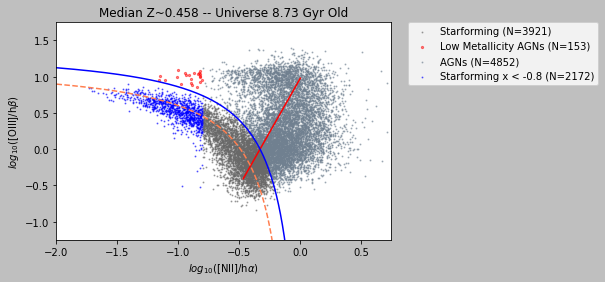

In [29]:
halpha = df_starform['ha'].values
halpha2 = df_low_met_agn['ha'].values
halpha3 = df_agn['ha'].values
halpha4 = df_starform_less['ha'].values
hbeta = df_starform['hb'].values
hbeta2 = df_low_met_agn['hb'].values
hbeta3 = df_agn['hb'].values
hbeta4 = df_starform_less['hb'].values
nii = df_starform['n2'].values
nii2 = df_low_met_agn['n2'].values
nii3 = df_agn['n2'].values
nii4 = df_starform_less['n2'].values
oiii = df_starform['o3'].values
oiii2 = df_low_met_agn['o3'].values
oiii3 = df_agn['o3'].values
oiii4 = df_starform_less['o3'].values

plot_bpt2(nii, halpha, oiii, hbeta, nii2, halpha2, oiii2, hbeta2, nii3, halpha3, oiii3, hbeta3, nii4, halpha4, oiii4, hbeta4, alpha = .5)

In [30]:
# finding hb equivalent width for sf galaxies with x < -0.8
hb_ew_2 = df_starform_less['hb_ew'].values
hb_ew_err_2 = df_starform_less['hb_ew_err'].values
hb_ew_3 = ((hb_ew_2)/(hb_ew_err_2))

In [31]:
# finding hb equivalent width for sf galaxies with x < -0.8
print(stats.median(hb_ew_3))

37.15684744052622


In [32]:
df5 = df_low_met_agn.drop(columns=['Type', 'ha', 'ha_err', 'hb', 'hb_err', 'n2', 'n2_err', 'o3', 'o3_err', 'z', 'hb_ew', 'hb_ew_err'])

In [33]:
df5['plate2'] = df5['plate']

In [34]:
df5['spec'] = '/spec'
df5['extension'] = '.fits'

In [35]:
df5[['plate', 'spec', 'plate2', 'mjd', 'fiber', 'extension']]

,plate,spec,plate2,mjd,fiber,extension
487,11312,/spec,11312,58433,676,.fits
767,3674,/spec,3674,55182,551,.fits
1044,3783,/spec,3783,55246,882,.fits
1190,3817,/spec,3817,55277,677,.fits
2779,4395,/spec,4395,55828,415,.fits
3379,4603,/spec,4603,55999,679,.fits
3381,4604,/spec,4604,55983,433,.fits
3454,4624,/spec,4624,55654,471,.fits
3465,4628,/spec,4628,55646,103,.fits
3962,4763,/spec,4763,55869,148,.fits


In [36]:
cols = ['plate', 'spec']
df5['combined'] = df5[cols].apply(lambda row: ''.join(row.values.astype(str)), axis=1)

In [37]:
cols2 = ['plate2', 'mjd', 'fiber']
df5['combined2'] = df5[cols2].apply(lambda row: '-'.join(row.values.astype(str)), axis=1)

In [38]:
cols3 = ['combined2', 'extension']
df5['combined3'] = df5[cols3].apply(lambda row: ''.join(row.values.astype(str)), axis=1)

In [39]:
cols4 = ['combined', 'combined3']
df5['combined4'] = df5[cols4].apply(lambda row: '-'.join(row.values.astype(str)), axis=1)

In [40]:
df5 = df5.drop(columns=['plate', 'mjd', 'fiber', 'plate2', 'spec', 'extension', 'combined', 'combined2', 'combined3'])

In [41]:
df5

,combined4
487,11312/spec-11312-58433-676.fits
767,3674/spec-3674-55182-551.fits
1044,3783/spec-3783-55246-882.fits
1190,3817/spec-3817-55277-677.fits
2779,4395/spec-4395-55828-415.fits
3379,4603/spec-4603-55999-679.fits
3381,4604/spec-4604-55983-433.fits
3454,4624/spec-4624-55654-471.fits
3465,4628/spec-4628-55646-103.fits
3962,4763/spec-4763-55869-148.fits


In [42]:
# df5.to_csv('eboss-0.4-speclist-2-less.txt', header=None, index=None, sep=' ', mode='a')